In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import eigh

class GraphLearningSGA_barrier:
    def __init__(self, alpha=0.01, gamma=100, max_iter=50, tol=1e-4, epsilon=1e-3):
        self.alpha = alpha
        self.gamma = gamma
        self.max_iter = max_iter
        self.tol = tol
        self.epsilon = epsilon
        self.w_ = None
        self.L_ = None
        self.A_ = None

    def _L_operator(self, w, p, iu):
        """Opérateur Laplacien L(w)."""
        L = np.zeros((p, p))
        L[iu] = -w
        L = L + L.T
        np.fill_diagonal(L, -np.sum(L, axis=1))
        return L

    def _A_operator(self, w, p, iu):
        """Opérateur Adjacence A(w)."""
        A = np.zeros((p, p))
        A[iu] = w
        A = A + A.T
        return A

    def _L_adjoint(self, M, p, iu):
        """Adjoint de l'opérateur Laplacien L*(M)."""
        diag = np.diag(M)
        return diag[iu[0]] + diag[iu[1]] - 2 * M[iu]

    def _A_adjoint(self, M, iu):
        """Adjoint de l'opérateur Adjacence A*(M)."""
        return 2 * M[iu]

    def fit(self, S):
        p = S.shape[0]
        n_edges = p * (p - 1) // 2
        iu = np.triu_indices(p, k=1)
        
        # Initialisation "Naive" (S^-1) souvent meilleure que random pour la convergence
        # On prend la valeur absolue de l'inverse de la covariance comme point de départ
        try:
            S_inv = np.linalg.pinv(S)
            w = np.abs(S_inv[iu])
        except:
            w = np.random.uniform(0.1, 1.0, n_edges)
        
        # J matrix
        J = (1.0 / p) * np.ones((p, p))

        # Initialisation spectrale
        A_init = self._A_operator(w, p, iu)
        psi, V = eigh(A_init)
        
        for t in range(self.max_iter):
            w_old = w.copy()
            
            # --- Matrices courantes ---
            Lw = self._L_operator(w, p, iu)
            Aw = self._A_operator(w, p, iu)
            
            # --- Mises à jour spectrales (V et psi) ---
            evals_temp, V = eigh(Aw)
            idx = np.argsort(evals_temp)[::-1]
            psi = evals_temp[idx]
            V = V[:, idx]
            
            # Projection Bipartite (Symétrie)
            psi_sym = np.zeros_like(psi)
            half = p // 2
            for i in range(half):
                val = (psi[i] - psi[p - 1 - i]) / 2.0
                psi_sym[i] = val
                psi_sym[p - 1 - i] = -val
            if p % 2 != 0: psi_sym[half] = 0
            psi = np.sort(psi_sym)[::-1] # Isotonic

            # --- Mise à jour de w (Gradient) ---
            try:
                inv_term = np.linalg.pinv(Lw + J)
            except:
                inv_term = np.linalg.pinv(Lw + J + 1e-6 * np.eye(p))
            
            # 1. Gradient des données (S) : C'EST LE TERME MANQUANT
            # Il pousse w à diminuer si la covariance S est forte
            grad_S = (1.0 / self.gamma) * self._L_adjoint(S, p, iu)
            
            # 2. Gradient du Log-Det (Inverse)
            # Il pousse w à augmenter pour garder la matrice définie positive
            # Attention au signe : on soustrait ce terme dans le gradient global
            grad_inv = (1.0 / self.gamma) * self._L_adjoint(inv_term, p, iu)
            
            # 3. Gradient Spectral (Structure Bipartite)
            M_spectral = V @ np.diag(psi) @ V.T
            grad_spectral = self._A_adjoint(Aw, iu) - self._A_adjoint(M_spectral, iu)
            
            # 4. Gradient Sparsité
            grad_sparsity = (self.alpha / self.gamma) * (1.0 / (self.epsilon + w))
            
            # COMBINAISON (MLE : S - inv)
            # On cherche S - inv = 0. Donc le gradient est (S - inv) + penalités
            grad = (grad_S - grad_inv) + grad_spectral + grad_sparsity
            
            # Pas de descente
            L_const = 2.0 + (1.0 / self.gamma) 
            
            # Mise à jour projetée
            w = np.maximum(0, w - (1.0 / L_const) * grad)

            # Convergence
            diff = np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-10)
            if diff < self.tol:
                print(f"Convergence à l'itération {t}")
                break
        
        self.w_ = w
        self.L_ = self._L_operator(w, p, iu)
        self.A_ = self._A_operator(w, p, iu)
        return self


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import eigh

class GraphLearningSGA:
    def __init__(self, alpha=0.01, gamma=100, max_iter=50, tol=1e-4, epsilon=1e-3):
        self.alpha = alpha
        self.gamma = gamma
        self.max_iter = max_iter
        self.tol = tol
        self.epsilon = epsilon
        self.w_ = None
        self.L_ = None
        self.A_ = None

    def _L_operator(self, w, p, iu):
        """Opérateur Laplacien L(w)."""
        L = np.zeros((p, p))
        L[iu] = -w
        L = L + L.T
        np.fill_diagonal(L, -np.sum(L, axis=1))
        return L

    def _A_operator(self, w, p, iu):
        """Opérateur Adjacence A(w)."""
        A = np.zeros((p, p))
        A[iu] = w
        A = A + A.T
        return A

    def _L_adjoint(self, M, p, iu):
        """Adjoint de l'opérateur Laplacien L*(M)."""
        diag = np.diag(M)
        return diag[iu[0]] + diag[iu[1]] - 2 * M[iu]

    def _A_adjoint(self, M, iu):
        """Adjoint de l'opérateur Adjacence A*(M)."""
        return 2 * M[iu]

    def fit(self, S):
        p = S.shape[0]
        n_edges = p * (p - 1) // 2
        iu = np.triu_indices(p, k=1)
        
        # Initialisation "Naive" (S^-1) souvent meilleure que random pour la convergence
        # On prend la valeur absolue de l'inverse de la covariance comme point de départ
        try:
            S_inv = np.linalg.pinv(S)
            w = np.abs(S_inv[iu])
        except:
            w = np.random.uniform(0.1, 1.0, n_edges)
        
        # J matrix
        J = (1.0 / p) * np.ones((p, p))
        K = S + self.alpha*(2*np.eye(p) - np.ones((p,p)))

        # Initialisation spectrale
        A_init = self._A_operator(w, p, iu)
        psi, V = eigh(A_init)
        
        for t in range(self.max_iter):
            w_old = w.copy()
            
            # --- Matrices courantes ---
            Lw = self._L_operator(w, p, iu)
            Aw = self._A_operator(w, p, iu)
            
            # --- Mises à jour spectrales (V et psi) ---
            evals_temp, V = eigh(Aw)
            idx = np.argsort(evals_temp)[::-1]
            psi = evals_temp[idx]
            V = V[:, idx]
            
            # Projection Bipartite (Symétrie)
            psi_sym = np.zeros_like(psi)
            half = p // 2
            for i in range(half):
                val = (psi[i] - psi[p - 1 - i]) / 2.0
                psi_sym[i] = val
                psi_sym[p - 1 - i] = -val
            if p % 2 != 0: psi_sym[half] = 0
            psi = np.sort(psi_sym)[::-1] # Isotonic

            # --- Mise à jour de w (Gradient) ---
            try:
                inv_term = np.linalg.pinv(Lw + J)
            except:
                inv_term = np.linalg.pinv(Lw + J + 1e-6 * np.eye(p))

            grad_inv = (1.0 / self.gamma) * self._L_adjoint(inv_term, p, iu)
            M_spectral = V @ np.diag(psi) @ V.T
            grad_spectral = self._A_adjoint(Aw,iu)
            grad_c = self._A_adjoint(M_spectral,iu) - (1/self.gamma)* self._L_adjoint(K,p,iu)
            
            grad = grad_inv + grad_spectral - grad_c
            
            # Pas de descente
            L_const = 2 + 1/self.gamma
            
            # Mise à jour projetée
            w = np.maximum(0, w - (1.0 / L_const) * grad)

            # Convergence
            diff = np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-10)
            if diff < self.tol:
                print(f"Convergence à l'itération {t}")
                break
    
        self.w_ = w
        self.L_ = self._L_operator(w, p, iu)
        self.A_ = self._A_operator(w, p, iu)
        return self


In [3]:
from sklearn.metrics import f1_score

def evaluate_graph_performance(W_true, W_learned, threshold=1e-5):
    """
    Calcule l'Erreur Relative (RE) et le F-score (FS) selon le papier.
    
    Args:
        W_true (np.array): La vraie matrice d'adjacence (Ground Truth).
        W_learned (np.array): La matrice apprise par l'algo.
        threshold (float): Valeur en dessous de laquelle une arête est considérée comme inexistante (0).
        
    Returns:
        dict: {'RE': float, 'FS': float}
    """
    # 1. Préparation : On ne garde que le triangle supérieur (sans la diagonale)
    # car les matrices sont symétriques.
    p = W_true.shape[0]
    iu = np.triu_indices(p, k=1)
    
    w_true_vec = W_true[iu]
    w_learned_vec = W_learned[iu]
    
    # 2. Calcul de l'Erreur Relative (RE) 
    # On compare les valeurs continues des poids
    diff_norm = np.linalg.norm(w_learned_vec - w_true_vec)
    true_norm = np.linalg.norm(w_true_vec)
    
    if true_norm == 0:
        re = 0.0 if diff_norm == 0 else np.inf
    else:
        re = diff_norm / true_norm

    # 3. Calcul du F-score (FS) [cite: 765]
    # On binarise les arêtes : 1 si poids > threshold, 0 sinon
    bin_true = (np.abs(w_true_vec) > threshold).astype(int)
    bin_learned = (np.abs(w_learned_vec) > threshold).astype(int)
    
    # Le calcul manuel de tp, fp, fn pour coller à la formule du papier :
    tp = np.sum((bin_true == 1) & (bin_learned == 1))
    fp = np.sum((bin_true == 0) & (bin_learned == 1))
    fn = np.sum((bin_true == 1) & (bin_learned == 0))
    
    denom = 2*tp + fp + fn
    if denom == 0:
        fs = 1.0 # Cas vide parfait
    else:
        fs = (2 * tp) / denom

    return {"RE": re, "FS": fs}


In [4]:
def make_block_k_component_laplacian(p=64, k=4, w_low=0.0, w_high=1.0, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    sizes = [p // k] * k
    assert sum(sizes) == p

    W_true = np.zeros((p, p), dtype=float)
    start = 0
    for sz in sizes:
        idx = np.arange(start, start + sz)
        W = rng.uniform(w_low, w_high, size=(sz, sz))
        W = 0.5 * (W + W.T)
        np.fill_diagonal(W, 0.0)
        W_true[np.ix_(idx, idx)] = W
        start += sz

    Theta_true = laplacian_from_W(W_true)
    return W_true, Theta_true

def make_er_noise_laplacian(p=64, p_edge=0.25, kappa=0.45, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    M = (rng.random((p, p)) < p_edge).astype(float)
    M = np.triu(M, 1)
    M = M + M.T

    W_er = rng.uniform(0.0, kappa, size=(p, p))
    W_er = 0.5 * (W_er + W_er.T)
    np.fill_diagonal(W_er, 0.0)
    W_er = M * W_er

    Theta_er = laplacian_from_W(W_er)
    return W_er, Theta_er

In [6]:
import numpy as np
import networkx as nx
from scipy.linalg import pinv, eigh
import matplotlib.pyplot as plt

# 1. GÉNÉRATION D'UN VRAI GRAPHE BIPARTI SPARSE
# ---------------------------------------------

n_nodes = 30
n1, n2 = 15, 15  # Deux groupes de 15 noeuds
# Probabilité de connexion faible (0.2) pour avoir un graphe sparse
G_true = nx.bipartite.random_graph(n1, n2, p=0.2, seed=42)
W_true = nx.to_numpy_array(G_true) 

# Création de la matrice de Précision (Laplacien + Regularisation)
# Theta = L_true + petite valeur diag pour inversibilité
L_true = np.diag(np.sum(W_true, axis=1)) - W_true
Theta_true = L_true + 1e-1 * np.eye(n_nodes)

# 2. SIMULATION DES DONNÉES (GMRF)
# --------------------------------
# On génère des échantillons X ~ N(0, Theta^-1) 
n_samples = 1000 # Nombre d'observations
Cov_true = pinv(Theta_true) # Inverse de la précision = Covariance vraie
# Génération des données multivariées
X = np.random.multivariate_normal(mean=np.zeros(n_nodes), cov=Cov_true, size=n_samples)
# Calcul de la Matrice de Covariance Empirique (S)
S_sample = np.cov(X.T) 


Lancement de la Grid Search sur 12 combinaisons...
Testing: alpha=0.01, gamma=10000 ... -> FS: 0.9725
Testing: alpha=0.05, gamma=10000 ... -> FS: 0.9725
Testing: alpha=0.1, gamma=10000 ... -> FS: 0.9725
Testing: alpha=0.01, gamma=10000 ... -> FS: 0.9725
Testing: alpha=0.05, gamma=10000 ... -> FS: 0.9725
Testing: alpha=0.1, gamma=10000 ... -> FS: 0.9725
Testing: alpha=0.01, gamma=100000 ...Convergence à l'itération 157
 -> FS: 0.9464
Testing: alpha=0.05, gamma=100000 ...Convergence à l'itération 160
 -> FS: 0.9464
Testing: alpha=0.1, gamma=100000 ...Convergence à l'itération 197
 -> FS: 0.9464
Testing: alpha=0.01, gamma=50000 ...Convergence à l'itération 146
 -> FS: 0.9464
Testing: alpha=0.05, gamma=50000 ...Convergence à l'itération 148
 -> FS: 0.9464
Testing: alpha=0.1, gamma=50000 ...Convergence à l'itération 150
 -> FS: 0.9464

MEILLEURE COMBINAISON TROUVÉE
Alpha : 0.01
Gamma : 10000.0
F-score : 0.9725
Relative Error : 0.2090


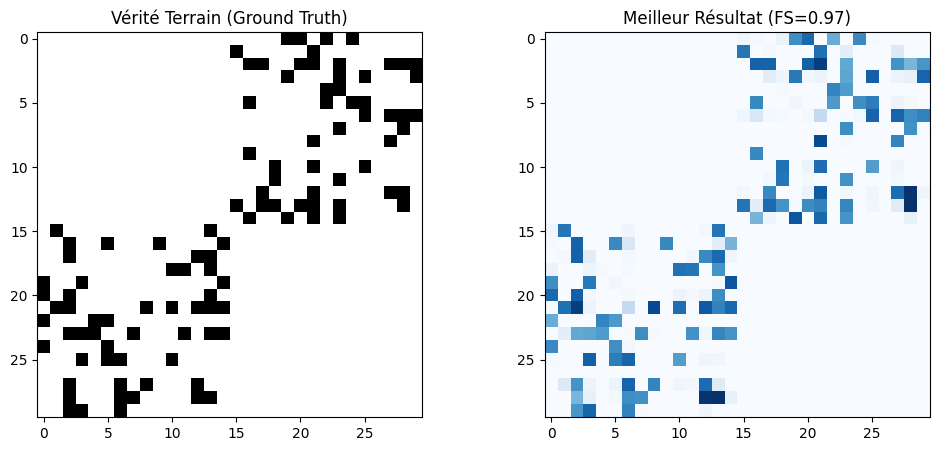

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Pour un joli tableau de résultats

# On définit une plage de recherche
alphas = [0.01, 0.05, 0.1]
gammas = [10000, 10000, 100000,50000] 

results = []

print(f"Lancement de la Grid Search sur {len(alphas)*len(gammas)} combinaisons...")

for g in gammas:
    for a in alphas:
        print(f"Testing: alpha={a}, gamma={g} ...", end="")
        
        # On réinitialise l'algo à chaque fois
        # Note: on réduit tolérance et iter pour aller vite lors du scan
        model = GraphLearningSGA(alpha=a, gamma=g, max_iter=300, tol=1e-4)
        model.fit(S_sample)
        
        # Nettoyage
        W_clean = model.A_.copy()
        W_clean[W_clean < 1e-3] = 0
        
        # Mesure
        met = evaluate_graph_performance(W_true, W_clean, threshold=0.2)
        
        print(f" -> FS: {met['FS']:.4f}")
        
        results.append({
            'alpha': a,
            'gamma': g,
            'FS': met['FS'],
            'RE': met['RE']
        })

# --- Affichage des Meilleurs Résultats ---
df_res = pd.DataFrame(results)
best_run = df_res.loc[df_res['FS'].idxmax()]

print("\n" + "="*40)
print(f"MEILLEURE COMBINAISON TROUVÉE")
print("="*40)
print(f"Alpha : {best_run['alpha']}")
print(f"Gamma : {best_run['gamma']}")
print(f"F-score : {best_run['FS']:.4f}")
print(f"Relative Error : {best_run['RE']:.4f}")

# --- Visualisation du Meilleur Graphe ---
# On relance le meilleur modèle pour l'afficher proprement
best_model = GraphLearningSGA(alpha=best_run['alpha'], gamma=best_run['gamma'], max_iter=1000, tol=1e-5)
best_model.fit(S_sample)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Vérité Terrain (Ground Truth)")
plt.imshow(W_true, cmap='Greys')
plt.subplot(1, 2, 2)
plt.title(f"Meilleur Résultat (FS={best_run['FS']:.2f})")
plt.imshow(best_model.A_, cmap='Blues')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import pinv

def run_figure16_experiment():
    # --- 1. PARAMÈTRES DU PAPIER ---
    n1, n2 = 40, 24
    p = n1 + n2
    p_bipartite = 0.70
    p_noise_er = 0.35
    n_samples = 500*p # Standard pour ce genre de dimension
    
    print(f"Scenario: G_bi({n1}, {n2}, {p_bipartite}) + Noise G_ER({p}, {p_noise_er})")

    # --- 2. GÉNÉRATION DU GRAPHE BIPARTI (Ground Truth) ---
    # Structure
    G_bi = nx.bipartite.random_graph(n1, n2, p=p_bipartite, seed=42)
    W_bi = nx.to_numpy_array(G_bi)
    
    # Poids uniformes [0.1, 1] comme spécifié
    # On multiplie le masque binaire par des poids aléatoires
    weights_bi = np.random.uniform(0.1, 1.0, size=(p, p))
    weights_bi = (weights_bi + weights_bi.T) / 2.0 # Symétrie
    W_bi = W_bi * weights_bi # Application des poids
    
    # --- 3. GÉNÉRATION DU BRUIT ERDOS-RENYI ---
    # Structure de bruit
    G_er = nx.erdos_renyi_graph(p, p=p_noise_er, seed=99)
    W_er = nx.to_numpy_array(G_er)
    
    # Poids du bruit (supposons même distribution [0.1, 1] ou légèrement plus faible)
    weights_er = np.random.uniform(0, 0.35, size=(p, p))
    weights_er = (weights_er + weights_er.T) / 2.0
    W_noise_component = W_er * weights_er
    
    # --- 4. CRÉATION DU GRAPHE "OBSERVÉ" (Bruité) ---
    # C'est la matrice de précision qui contient le bruit
    W_total_noisy = W_bi + W_noise_component
    # Note : W_total_noisy n'est PAS biparti. Il a des arêtes partout.
    
    # Construction du Laplacien bruité pour générer les données
    L_noisy = np.diag(np.sum(W_total_noisy, axis=1)) - W_total_noisy
    Theta_noisy = L_noisy
    
    # Génération des données X ~ N(0, Theta^-1)
    Cov_noisy = pinv(Theta_noisy)
    X = np.random.multivariate_normal(np.zeros(p), Cov_noisy, size=n_samples)
    S = np.cov(X.T)
    
    # --- 5. APPRENTISSAGE SGA ---
    print("Starting SGA algorithm...")
    # Paramètres suggérés pour ce niveau de bruit fort :
    # Gamma élevé pour forcer le nettoyage du bruit ER
    # Alpha modéré pour gérer la sparsité
    model = GraphLearningSGA(alpha=0.01, gamma=100000, max_iter=800, tol=1e-8)
    model.fit(S)
    
    W_learned = model.A_
    
    # --- 6. VISUALISATION (Style Figure 16) ---
    plt.figure(figsize=(18, 6))
    
    # A. Ground Truth (Ce qu'on veut retrouver)
    plt.subplot(1, 3, 1)
    plt.title("A. Ground Truth (Purely Bipartite)")
    plt.imshow(W_bi, cmap='Greys', interpolation='nearest')
    plt.xlabel(f"Empty blocs on the diagonals\n(N1={n1}, N2={n2})")
    
    # B. Noisy Precision (La réalité des données)
    plt.subplot(1, 3, 2)
    plt.title("B. Matrix with noise (Input)")
    plt.imshow(W_total_noisy, cmap='Greys', interpolation='nearest')
    plt.xlabel("Bipartite structure masked by the noise")
    
    # C. Resultat SGA
    plt.subplot(1, 3, 3)
    plt.title("C. SGA Reconstruction")
    # On seuille légèrement pour le visuel
    W_visu = W_learned.copy()
    W_visu[W_visu < 0.1] = 0
    plt.imshow(W_visu, cmap='Blues', interpolation='nearest')
    plt.xlabel("Bipartite structure recovered?")
    
    plt.tight_layout()
    plt.show()
    
    # --- 7. MESURES ---
    # On compare l'appris vs la Vérité Terrain (W_bi), pas vs le bruit
    metrics = evaluate_graph_performance(W_bi, W_learned, threshold=0.1)
    print("="*40)
    print(f"Results FIG. 16")
    print("="*40)
    print(f"F-score (Recovery)  : {metrics['FS']:.4f}")
    print(f"Relative Error (RE) : {metrics['RE']:.4f}")

# Lancement
run_figure16_experiment()

Monte Carlo (15 trials by level of noise)...
Analyse Kappa = 0.00
Convergence à l'itération 58
Convergence à l'itération 63
Convergence à l'itération 52
Convergence à l'itération 57
Convergence à l'itération 52
Convergence à l'itération 63
Convergence à l'itération 45
Convergence à l'itération 57
Convergence à l'itération 48
Convergence à l'itération 58
Convergence à l'itération 57
Convergence à l'itération 60
Convergence à l'itération 53
Convergence à l'itération 58
Convergence à l'itération 45
Convergence à l'itération 52
Convergence à l'itération 48
Convergence à l'itération 55
Convergence à l'itération 61
Convergence à l'itération 76
Convergence à l'itération 42
Convergence à l'itération 49
Convergence à l'itération 54
Convergence à l'itération 62
Convergence à l'itération 58
Convergence à l'itération 72
Convergence à l'itération 49
Convergence à l'itération 58
Convergence à l'itération 45
Convergence à l'itération 55
Analyse Kappa = 0.20
Convergence à l'itération 106
Convergence à

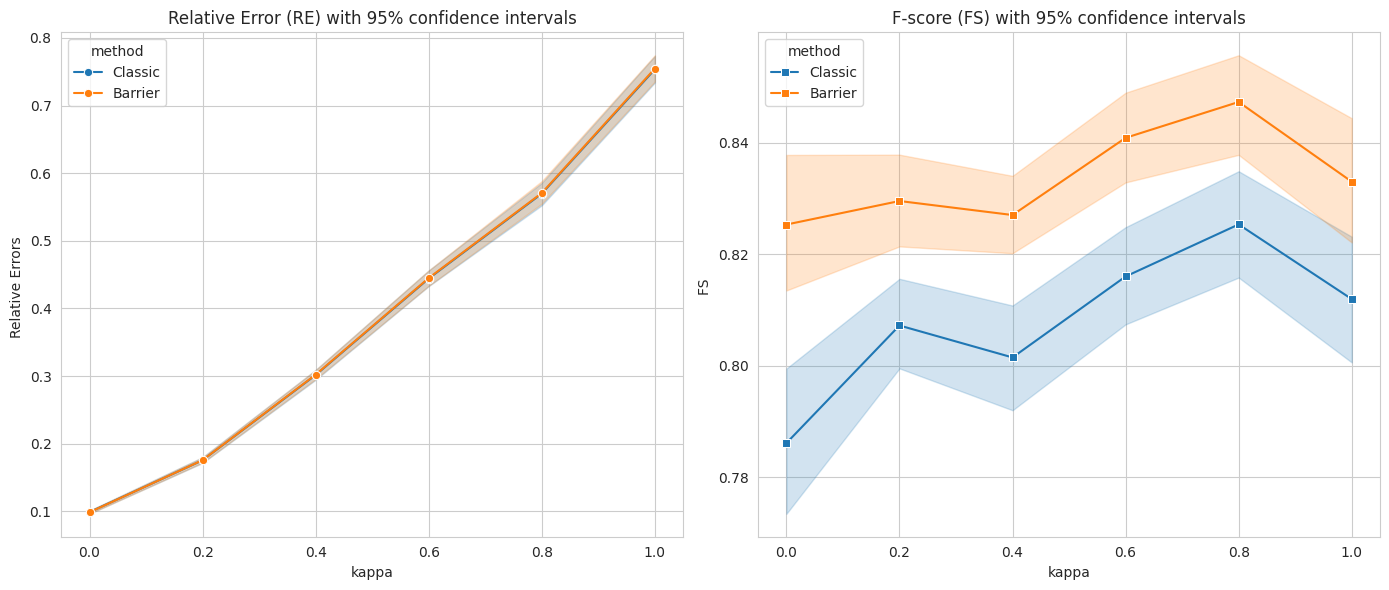

In [13]:
import seaborn as sns
import pandas as pd
def run_monte_carlo_sensitivity(n_trials=20): # Augmenté pour la robustesse stat
    p = 32
    n1, n2 = 20, 12
    n_samples = p * 500 
    noise_intensities = np.linspace(0.0, 1.0, 6)
    
    res = []

    print(f"Monte Carlo ({n_trials} trials by level of noise)...")

    for kappa in noise_intensities:
        print(f"Analyse Kappa = {kappa:.2f}")
        for run in range(n_trials):
            # 1. Génération du Ground Truth (Bipartite)
            G_bi = nx.bipartite.random_graph(n1, n2, p=0.7)
            W_bi = nx.to_numpy_array(G_bi) * np.random.uniform(0.1, 1.0, (p, p))
            W_bi = (W_bi + W_bi.T) / 2
            
            # 2. Injection de bruit structurel
            W_noise = (nx.to_numpy_array(nx.erdos_renyi_graph(p, 0.35)) * np.random.uniform(0, kappa, (p, p)))
            W_noise = (W_noise + W_noise.T) / 2
            
            W_noisy = W_bi + W_noise
            L_noisy = np.diag(np.sum(W_noisy, axis=1)) - W_noisy
            
            # 3. Échantillonnage
            Cov = np.linalg.pinv(L_noisy + 1e-6*np.eye(p))
            X = np.random.multivariate_normal(np.zeros(p), Cov, n_samples)
            S = np.cov(X.T)

            # 4. Tests des méthodes
            # Méthode Classique
            m_classic = GraphLearningSGA(alpha=0.1, gamma=1e5, max_iter=500).fit(S)
            eval_c = evaluate_graph_performance(W_bi, m_classic.A_)
            
            # Méthode Barrière
            m_barrier = GraphLearningSGA_barrier(alpha=0.1, gamma=1e5, max_iter=500).fit(S)
            eval_b = evaluate_graph_performance(W_bi, m_barrier.A_)
            
            # Stockage des données brutes pour analyse stats
            res.append({'kappa': kappa, 'trial': run, 'method': 'Classic', 'RE': eval_c["RE"], 'FS': eval_c["FS"]})
            res.append({'kappa': kappa, 'trial': run, 'method': 'Barrier', 'RE': eval_b["RE"], 'FS': eval_b["FS"]})

    df = pd.DataFrame(res)
    
    # --- Analyse Statistique ---
    stats = df.groupby(['kappa', 'method'])[['RE', 'FS']].agg(['mean', 'std', 'sem']).reset_index()
    # sem = Standard Error of the Mean (utile pour les barres d'erreur)
    
    print("\n--- Résumé Statistique (Premières lignes) ---")
    print(stats.head())

    # --- Visualisation Avancée ---
    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")

    # Graphique RE
    plt.subplot(1, 2, 1)
    sns.lineplot(data=df, x='kappa', y='RE', hue='method', marker='o', errorbar=('ci', 95))
    plt.title('Relative Error (RE) with 95% confidence intervals')
    plt.ylabel('Relative Errors ')

    # Graphique FS
    plt.subplot(1, 2, 2)
    sns.lineplot(data=df, x='kappa', y='FS', hue='method', marker='s', errorbar=('ci', 95))
    plt.title('F-score (FS) with 95% confidence intervals')
    plt.ylabel('FS ')

    plt.tight_layout()
    plt.savefig('monte_carlo_analysis.png')
    df.to_csv('monte_carlo_results_raw.csv', index=False)
    
    return df, stats

df_raw, df_stats = run_monte_carlo_sensitivity(n_trials=15)

NYCBIKES

In [14]:
df_raw = pd.read_csv('202301-citibike-tripdata_1.csv')

/tmp/ipykernel_700513/3877853172.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('202301-citibike-tripdata_1.csv')


In [15]:
def get_bipartite_data(df, n_stations=50):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df['h_start'] = df['started_at'].dt.floor('H')
    df['h_end'] = df['ended_at'].dt.floor('H')
    # Calculer le volume total par station
    stats_out = df['start_station_name'].value_counts()
    stats_in = df['end_station_name'].value_counts()

    # Créer un DataFrame de comparaison
    diff_df = pd.DataFrame({'out': stats_out, 'in': stats_in}).fillna(0)
    diff_df['net'] = diff_df['out'] - diff_df['in']

    # Prendre les stations les plus asymétriques
    top_sources = diff_df.sort_values('net', ascending=False).head(50).index
    top_sinks = diff_df.sort_values('net', ascending=True).head(50).index
    
    top_stations = df['start_station_name'].value_counts().nlargest(n_stations).index
    
    outflow = df[df['start_station_name'].isin(top_sources)].groupby(['h_start', 'start_station_name']).size().unstack(fill_value=0)
    inflow = df[df['end_station_name'].isin(top_sinks)].groupby(['h_end', 'end_station_name']).size().unstack(fill_value=0)
    
    common_index = outflow.index.intersection(inflow.index)
    outflow = outflow.loc[common_index]
    inflow = inflow.loc[common_index]

    combined_flow = pd.concat([outflow, inflow], axis=1)

    # --- ÉTAPE DE DIAGNOSTIC ET PRÉ-TRAITEMENT ---
    # 1. Log-transformation (on utilise log1p car log1p(x) = log(1+x), gère les 0)
    # Cela stabilise la variance (hétéroscédasticité)
    combined_log = np.log1p(combined_flow)
    
    # 2. First-order Differencing (Variation d'une heure à l'autre)
    # Cela rend la série stationnaire en supprimant les tendances journalières
    combined_diff = combined_log.diff().dropna()
    
    # 3. Normalisation (Z-score sur les variations)
    combined_flow_norm = (combined_diff - combined_diff.mean()) / combined_diff.std()
    
    # Matrice de corrélation sur les données stationnarisées
    S_full = np.corrcoef(combined_flow_norm.T)
    
    # MASQUAGE
    mask = np.zeros_like(S_full)
    mask[:n_stations, n_stations:] = 1  
    mask[n_stations:, :n_stations] = 1  
    
    S_bipartite = S_full * mask 
    
    return S_bipartite, combined_flow_norm, top_stations
S_bip, ts_combined, stations = get_bipartite_data(df_raw)

/tmp/ipykernel_700513/464555595.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['h_start'] = df['started_at'].dt.floor('H')
/tmp/ipykernel_700513/464555595.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['h_end'] = df['ended_at'].dt.floor('H')


Convergence à l'itération 0


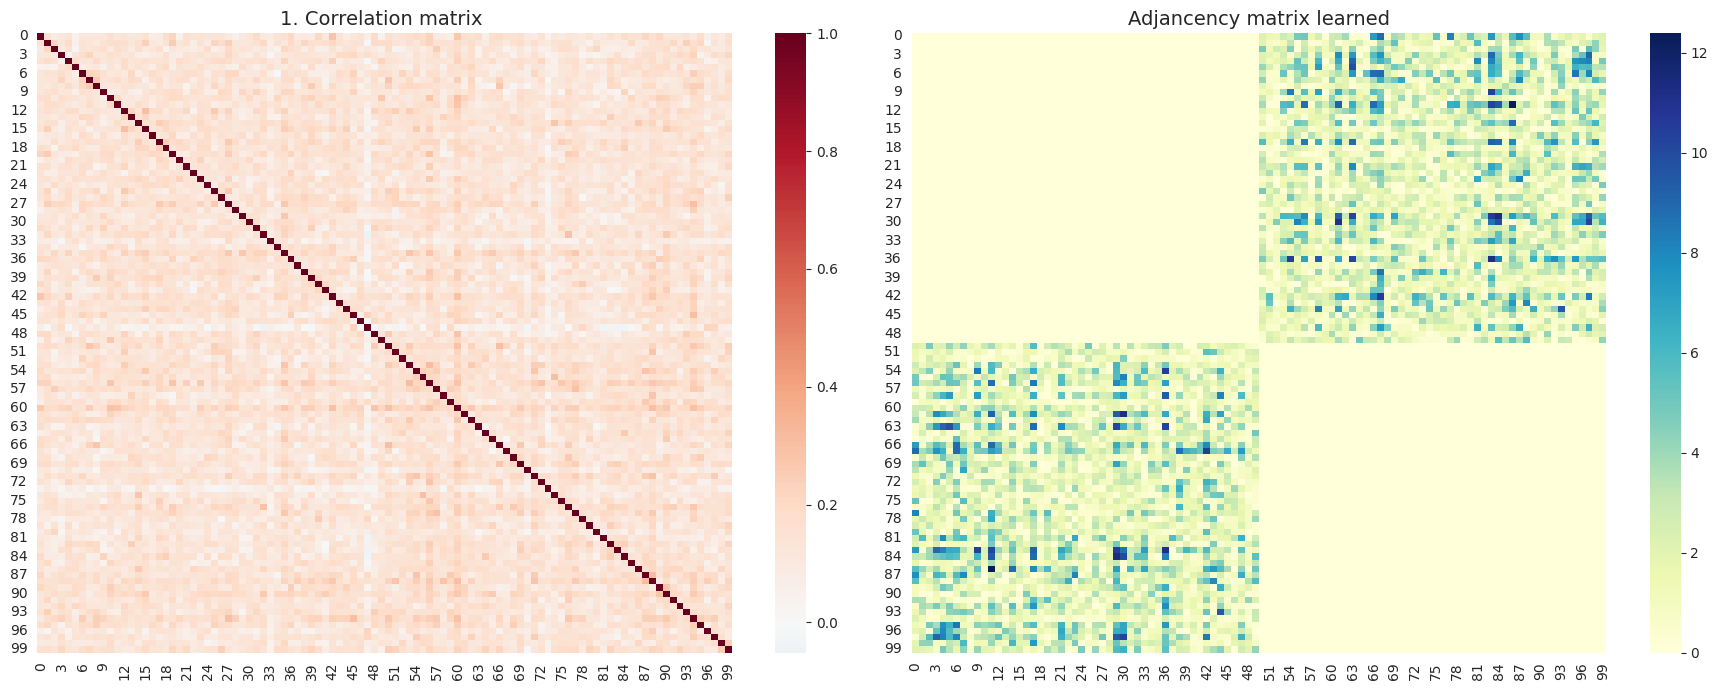

Number of edges conserved : 2499 sur 4950


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

model = GraphLearningSGA(alpha=0.05, gamma=1e5, max_iter=100)
model.fit(S_bip)

fig, ax = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(np.corrcoef(ts_combined.T), ax=ax[0], cmap='RdBu_r', center=0, cbar=True)
ax[0].set_title("1. Correlation matrix ", fontsize=14)
00
sns.heatmap(model.A_, ax=ax[1], cmap='YlGnBu', cbar=True)
ax[1].set_title("Adjancency matrix learned", fontsize=14)

plt.tight_layout()
plt.show()

# Petit check de diagnostic
n_edges = np.count_nonzero(model.w_ > 1e-4)
print(f"Number of edges conserved : {n_edges} sur {len(model.w_)}")

In [22]:
def get_regular_data(df, n_stations=50):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df['h_start'] = df['started_at'].dt.floor('H')
    df['h_end'] = df['ended_at'].dt.floor('H')
    # Calculer le volume total par station
    stats_out = df['start_station_name'].value_counts()
    stats_in = df['end_station_name'].value_counts()

    # Créer un DataFrame de comparaison
    diff_df = pd.DataFrame({'out': stats_out, 'in': stats_in}).fillna(0)
    diff_df['net'] = diff_df['out'] - diff_df['in']

    # Prendre les stations les plus asymétriques
    top_sources = diff_df.sort_values('net', ascending=False).head(50).index
    top_sinks = diff_df.sort_values('net', ascending=True).head(50).index
    
    top_stations = df['start_station_name'].value_counts().nlargest(n_stations).index
    
    outflow = df[df['start_station_name'].isin(top_sources)].groupby(['h_start', 'start_station_name']).size().unstack(fill_value=0)
    inflow = df[df['end_station_name'].isin(top_sinks)].groupby(['h_end', 'end_station_name']).size().unstack(fill_value=0)
    
    common_index = outflow.index.intersection(inflow.index)
    outflow = outflow.loc[common_index]
    inflow = inflow.loc[common_index]

    combined_flow = pd.concat([outflow, inflow], axis=1)

    # --- ÉTAPE DE DIAGNOSTIC ET PRÉ-TRAITEMENT ---
    # 1. Log-transformation (on utilise log1p car log1p(x) = log(1+x), gère les 0)
    # Cela stabilise la variance (hétéroscédasticité)
    combined_log = np.log1p(combined_flow)
    
    # 2. First-order Differencing (Variation d'une heure à l'autre)
    # Cela rend la série stationnaire en supprimant les tendances journalières
    combined_diff = combined_log.diff().dropna()
    
    # 3. Normalisation (Z-score sur les variations)
    combined_flow_norm = (combined_diff - combined_diff.mean()) / combined_diff.std()
    
    # Matrice de corrélation sur les données stationnarisées
    S_full = np.corrcoef(combined_flow_norm.T)
    
    return S_full, combined_flow_norm, top_stations
S_full, ts_combined_regular, stations_regular = get_regular_data(df_raw)

/tmp/ipykernel_700513/960530135.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['h_start'] = df['started_at'].dt.floor('H')
/tmp/ipykernel_700513/960530135.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['h_end'] = df['ended_at'].dt.floor('H')


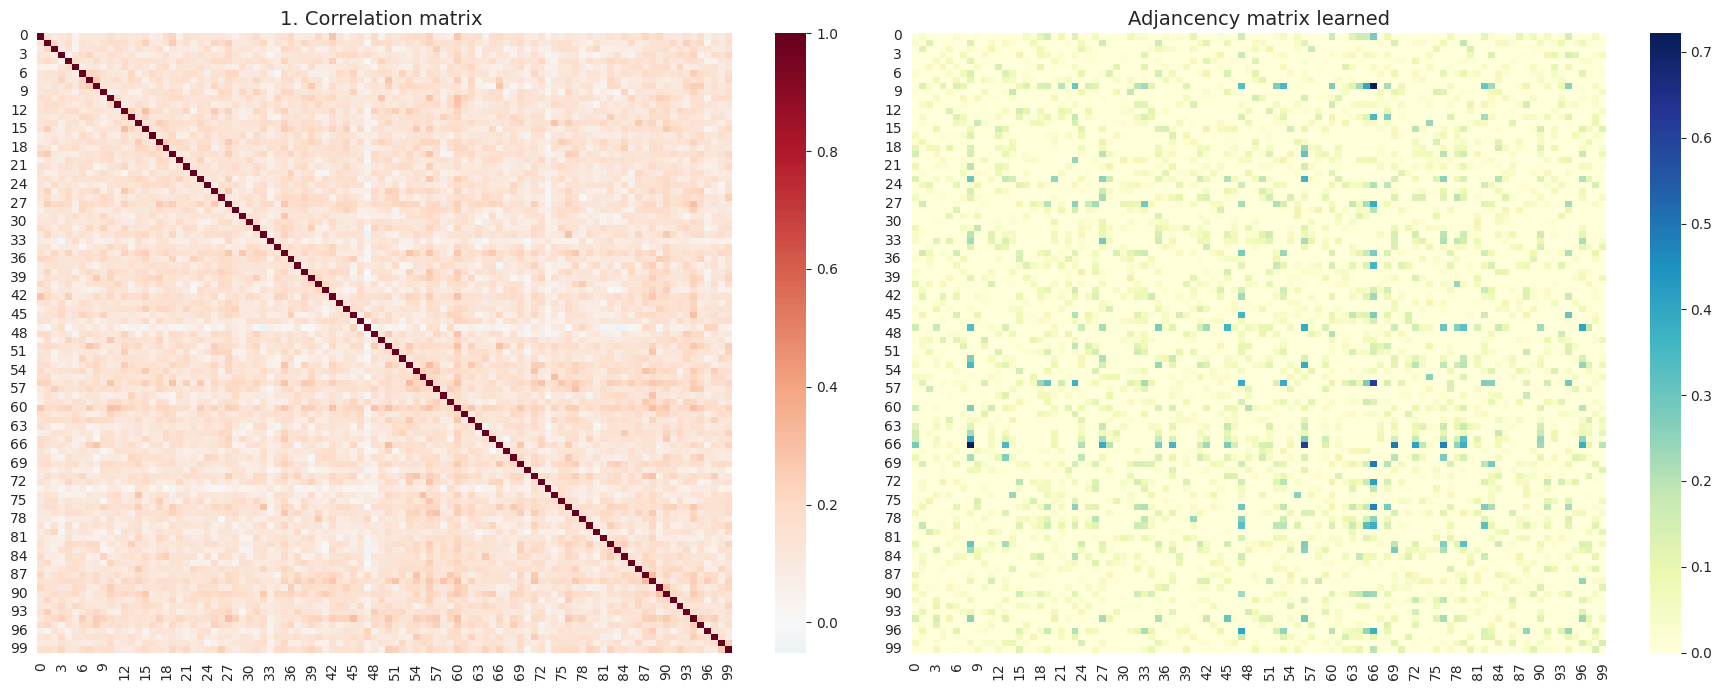

Number of edges conserved : 1924 sur 4950


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

model = GraphLearningSGA(alpha=0.05, gamma=1e5, max_iter=100)
model.fit(S_full)

fig, ax = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(S_full, ax=ax[0], cmap='RdBu_r', center=0, cbar=True)
ax[0].set_title("1. Correlation matrix ", fontsize=14)
00
sns.heatmap(model.A_, ax=ax[1], cmap='YlGnBu', cbar=True)
ax[1].set_title("Adjancency matrix learned", fontsize=14)

plt.tight_layout()
plt.show()

# Petit check de diagnostic
n_edges = np.count_nonzero(model.w_ > 1e-4)
print(f"Number of edges conserved : {n_edges} sur {len(model.w_)}")

In [18]:
import numpy as np
import folium

def map_bipartite_flows(model, top_stations, df_coords):
    n_stations = len(top_stations)
    A = model.A_
    
    # Récupération des coordonnées uniques
    geo = df_coords.drop_duplicates('start_station_name').copy()
    geo_map = geo.set_index('start_station_name')[['start_lat', 'start_lng']].T.to_dict('list')
    
    m = folium.Map(location=[40.73, -73.94], zoom_start=13, tiles='cartodbpositron')

    for i, name in enumerate(top_stations):
        if name in geo_map:
            pos = geo_map[name]
            
            # --- CALCUL DES POIDS BIPARTIS ---
            out_weight = A[i, n_stations:].sum() # Force Départ
            in_weight = A[:n_stations, n_stations + i].sum() # Force Arrivée

            # --- LOGIQUE DE SELECTION DU CERCLE UNIQUE ---
            if out_weight >= in_weight:
                # La station est majoritairement un point de DÉPART
                main_weight = out_weight
                color = '#E74C3C' # Rouge
                label = "Départ"
            else:
                # La station est majoritairement un point d'ARRIVÉE
                main_weight = in_weight
                color = '#3498DB' # Bleu
                label = "Arrivée"

            # On ne dessine qu'UN SEUL cercle
            folium.CircleMarker(
                location=pos,
                radius=min(25, 5 + main_weight * 30), # Rayon basé sur la force max
                color=color,
                fill=True,
                fill_opacity=0.6,
                popup=f"<b>{name}</b><br>Type dominant: {label}<br>Force: {main_weight:.3f}"
            ).add_to(m)

    # 3. TRACÉ DES LIAISONS
    for i in range(n_stations):
        for j in range(n_stations):
            weight = A[i, n_stations + j]
            if weight > 0.08:
                start_st, end_st = top_stations[i], top_stations[j]
                if start_st in geo_map and end_st in geo_map:
                    folium.PolyLine(
                        locations=[geo_map[start_st], geo_map[end_st]],
                        color='#7F8C8D',
                        weight=1,
                        opacity=0.2,
                        tooltip=f"Flux : {start_st} -> {end_st}"
                    ).add_to(m)

    return m

# Affichage
map_biparti = map_bipartite_flows(model, stations, df_raw)
map_biparti

In [24]:
import pandas as pd

def map_stations_by_time(df, top_stations, start_hour, end_hour):
    """
    Crée une carte pour une tranche horaire spécifique.
    df: DataFrame contenant 'started_at', 'start_station_name', 'end_station_name', 'start_lat', 'start_lng'
    """
    # 1. Conversion en datetime et filtrage
    df['started_at'] = pd.to_datetime(df['started_at'])
    mask = (df['started_at'].dt.hour >= start_hour) & (df['started_at'].dt.hour < end_hour)
    df_slot = df[mask].copy()

    # 2. Préparation de la carte
    m = folium.Map(location=[40.73, -73.94], zoom_start=13, tiles='cartodbpositron')
    
    # Coordonnées (on garde les uniques pour le placement)
    geo_map = df.drop_duplicates('start_station_name').set_index('start_station_name')[['start_lat', 'start_lng']].T.to_dict('list')

    for name in top_stations:
        if name in geo_map:
            pos = geo_map[name]
            
            # --- CALCUL DES FORCES RÉELLES SUR LE CRÉNEAU ---
            # Sorties (Out)
            out_weight = len(df_slot[df_slot['start_station_name'] == name])
            # Entrées (In)
            in_weight = len(df_slot[df_slot['end_station_name'] == name])
            
            # Normalisation simple pour l'affichage (à ajuster selon ton volume de données)
            total_activity = out_weight + in_weight
            if total_activity == 0: continue # On saute si aucune activité

            # --- LOGIQUE DE DOMINANCE ---
            if out_weight >= in_weight:
                color = '#E74C3C' # Rouge (Source)
                label = "Départ"
                force = out_weight
            else:
                color = '#3498DB' # Bleu (Cible)
                label = "Arrivée"
                force = in_weight

            # Rayon dynamique (ajusté au flux du moment)
            # On utilise un log ou une racine carrée pour éviter les cercles géants
            radius_size = np.sqrt(force) * 2 

            folium.CircleMarker(
                location=pos,
                radius=min(30, max(5, radius_size)),
                color=color,
                fill=True,
                fill_opacity=0.6,
                popup=f"<b>{name}</b><br>Slot: {start_hour}h-{end_hour}h<br>Dominance: {label}<br>Flux: {force} vélos"
            ).add_to(m)

    return m

# --- UTILISATION ---
# Pour voir les flux du MATIN (7h - 10h)
map_matin = map_stations_by_time(df_raw, stations, 18, 20) # change dates to get hourly data
map_matin